# CNN Model VGG16

## Imports and inital setup

In [85]:
# Imports
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh

SEED = 42
NUM_EPOCHS = 30
BATCH_SIZE = 32

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (224, 224)

### Loading (augmented) metadata as test, train, validation from files

In [86]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
3116,HAM_0007225,aug_aigEr3ISIC_0032247.jpg,df,histo,75.0,male,lower extremity,vienna_dias,not_skin_cancer,./../data/jpgs/aug_aigEr3ISIC_0032247.jpg
3471,HAM_0005663,aug_fpWsaUISIC_0026417.jpg,df,consensus,30.0,male,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_fpWsaUISIC_0026417.jpg
1189,HAM_0005711,ISIC_0033911.jpg,mel,histo,35.0,male,back,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0033911.jpg
3251,HAM_0000024,aug_FJvLmuISIC_0027141.jpg,df,consensus,45.0,female,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/aug_FJvLmuISIC_0027141.jpg
276,HAM_0004517,ISIC_0025359.jpg,nv,follow_up,5.0,male,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0025359.jpg
2449,HAM_0005989,aug_uHkXlrISIC_0033123.jpg,vasc,histo,25.0,female,back,vidir_modern,not_skin_cancer,./../data/jpgs/aug_uHkXlrISIC_0033123.jpg
2122,HAM_0001852,aug_kxwgeEISIC_0033749.jpg,vasc,histo,80.0,male,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_kxwgeEISIC_0033749.jpg
739,HAM_0000719,ISIC_0026902.jpg,bcc,histo,80.0,male,abdomen,rosendahl,skin_cancer,./../data/jpgs/ISIC_0026902.jpg
1124,HAM_0006802,ISIC_0032610.jpg,mel,histo,40.0,male,upper extremity,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0032610.jpg
2099,HAM_0005155,aug_Ws7OGnISIC_0032076.jpg,vasc,histo,85.0,male,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_Ws7OGnISIC_0032076.jpg


## Setting up the image data generator for training and validation

Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling

In [87]:
# Setting up the Image Data Generator for the train data set - including augmentation


datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
    preprocessing_function=preprocess_input,  # VGG16 specific preprocessing
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0, #see above
    preprocessing_function=preprocess_input,  # VGG16 specific preprocessing
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.
Found 3504 validated image filenames belonging to 7 classes.


# Adding an neural network model to test the data

## VGG16 Model
The VGG16 is a pre-trained Convolutional Neural Network (CNN) model proposed by K. Simonyan and A. Zisserman from the University of Oxford's Visual Geometry Group Lab. The model was proposed in their 2014 paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" and won the 1st and 2nd places in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014 geeksforgeeks.org. It is considered one of the best vision model architectures to date due to its simplicity and high performance builtin.com.

[Source:Tensorflow Applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)

Architecture:

*Input:*

Conv 1-1,
Conv 1-2,
Pooling

Conv 2-1,
Conv 2-2,
Pooling

Conv 3-1,
Conv 3-2,
Conv 3-3,
Pooling

Conv 4-1,
Conv 4-2,
Conv 4-3,
Pooling

Conv 5-1,
Conv 5-2,
Conv 5-3,
Pooling

Dense,
Dense,
Dense

*Output*


In [88]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the VGG16 model
vgg16_model.trainable = False
# Add custom layers on top of VGG16
x = Conv2D(64, (3, 3), activation='relu')(vgg16_model.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(7, activation='softmax')(x)  # Replace num_classes with your number of classes

# Create the combined model
model = Model(inputs=vgg16_model.input, outputs=x)




loading the VGG16 model
from matplotlib.dates import drange


vgg16_model = VGG16(
    include_top=False, # do not include the top layer, we will add our own
    weights= "imagenet", # use the weights that the model was trained on
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), # the input shape of the images (3 channels, width, height)
    pooling="max", # the type of pooling to use when we add the top layer (average pooling)
)

# Add custom layers on top of VGG16
x = Conv2D(64, (3, 3), activation='relu')(base_model.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(, activation='softmax')(x)

In [89]:

from tensorflow.keras.optimizers import SGD

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9)

# compile your model with the optimizer
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Model Training

In [90]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/30
110/110 [==============================] - 713s 7s/step - loss: 1.8502 - accuracy: 0.2326 - val_loss: 1.8238 - val_accuracy: 0.0789
Epoch 2/30
110/110 [==============================] - 748s 7s/step - loss: 1.6157 - accuracy: 0.3599 - val_loss: 2.0896 - val_accuracy: 0.1633
Epoch 3/30
110/110 [==============================] - 744s 7s/step - loss: 1.4927 - accuracy: 0.4192 - val_loss: 2.0964 - val_accuracy: 0.1043
Epoch 4/30
110/110 [==============================] - 765s 7s/step - loss: 1.4312 - accuracy: 0.4426 - val_loss: 1.4762 - val_accuracy: 0.3375
Epoch 5/30
110/110 [==============================] - 756s 7s/step - loss: 1.3271 - accuracy: 0.5034 - val_loss: 1.6525 - val_accuracy: 0.3545
Epoch 6/30
110/110 [==============================] - 876s 8s/step - loss: 1.2773 - accuracy: 0.5071 - val_loss: 1.6969 - val_accuracy: 0.3550
Epoch 7/30
110/110 [==============================] - 868s 8s/step - loss: 1.2081 - accuracy: 0.5414 - val_loss: 1.4589 - val_accuracy: 0.4368

2023-09-27 16:32:02.269486: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: './../data/jpgs/aug_e0RklNISIC_0033001.jpg'
Traceback (most recent call last):

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capston

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: './../data/jpgs/aug_e0RklNISIC_0033001.jpg'
Traceback (most recent call last):

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]
          ~^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: './../data/jpgs/aug_e0RklNISIC_0033001.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_89685]

## Plotting accuracy and loss of train and validation set

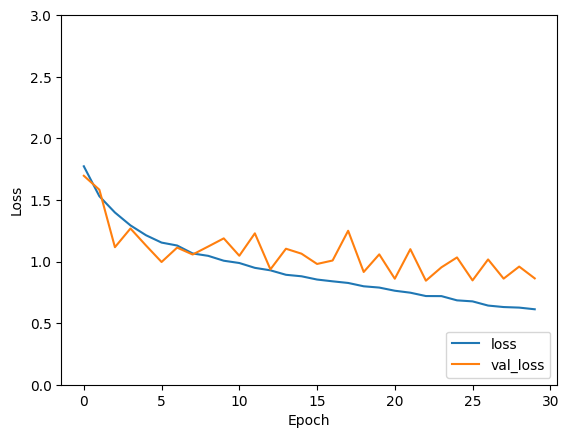

In [ ]:
# plot the loss functions 
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

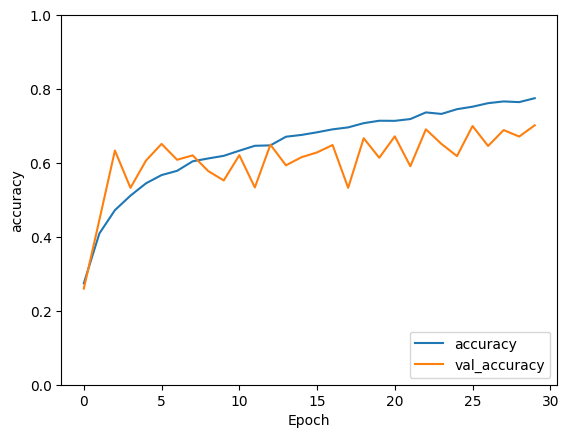

In [ ]:
# plot the loss functions 
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Evaluating the model on the test set

In [ ]:
#preprocess the test images into BGR format
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)




Evaluate on test data
63/63 [==============================] - 258s 4s/step - loss: 20.0888 - accuracy: 0.4518
test loss, test acc: [20.088777542114258, 0.45182228088378906]


In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 255s - loss: 32.4261 - accuracy: 0.2851 - 255s/epoch - 4s/step


## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/da.ma.ro/Documents/Capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
